# PyTorch Deep Learning Frameworks

Data loader:
1. Perform data preprocessing by modifying the Dataloader to  read from the csv file.
2. Split the dataset into Train, Validation and Test sets. Create their corresponding Dataloaders.

Model:
1. Develop a deep learning model with a) one CNN block and b) 2 CNN block to solve this classiﬁcation task. (Remember a CNN block = CNN layer + ReLU activation + Maxpool layer)
2. Train and evaluate your models to establish a baseline of performance.
3. Finalize your models to make predictions on new images.
4. Tweak the network's hyper-parameters to make each model overﬁt and underﬁt.

Optimization:
1. Diagnose the models for each case (overﬁt/underﬁt), and explain the model's behavior by using the learning curves (learning curves are plots of training and validation losses for each epoch).
2. Benchmark your model's performance using SGD, Momentum, and ADAM optimization techniques.

Discussion:
1. Discuss if adding the second CNN block has improved the model performance.
2. Experiment with kernel_size 3 and 5 for the CNN layer.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data loader:

Perform data preprocessing by modifying the Dataloader to  read from the csv file.

In [2]:
# Load the CSV file
data = pd.read_csv("MNIST_dataset.csv")

# Separate features (X) and labels (y)
X = data.iloc[:, :-1].values  # All columns except the last one
y = data.iloc[:, -1].values   # Last column

# Split the data into training (70%), validation (10%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 140 samples
Validation set size: 20 samples
Test set size: 40 samples


Split the dataset into Train, Validation and Test sets. Create their corresponding Dataloaders.

In [3]:
# Convert and reshape training data
X_train_tensor = torch.tensor(X_train, dtype =torch.float32).view(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train)


# Convert and reshape validation data
X_val_tensor = torch.tensor(X_val, dtype =torch.float32).view(-1, 1, 28, 28)
y_val_tensor = torch.tensor(y_val)


# Convert and reshape test data
X_test_tensor = torch.tensor(X_test, dtype =torch.float32).view(-1, 1, 28, 28)
y_test_tensor = torch.tensor(y_test)


print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Validation tensor shape: {X_val_tensor.shape}")
print(f"Test tensor shape: {X_test_tensor.shape}")

# Created TensorDataset instances for each dataset split.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Training tensor shape: torch.Size([140, 1, 28, 28])
Validation tensor shape: torch.Size([20, 1, 28, 28])
Test tensor shape: torch.Size([40, 1, 28, 28])


## Visualize the data:

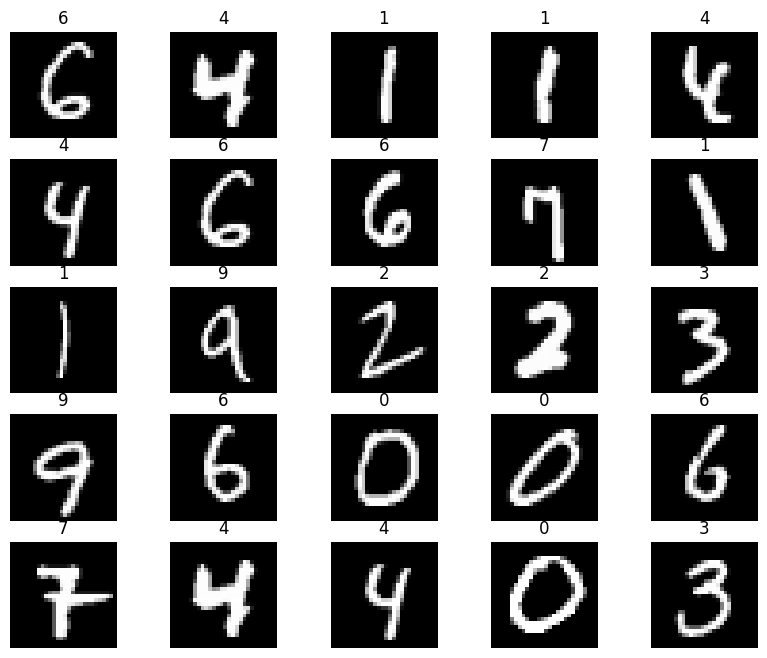

In [4]:
# Visualize images from the training dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    # Randomly select an index from the training dataset
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    # Process the image and label
    img = img.squeeze()  # Remove the channel dimension
    label = label.item()  # Convert tensor to scalar
    
    # Add subplot and plot the image
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    
plt.show()


## Building `DataLoaders` classes to load data

In [5]:
# Create DataLoaders

train_loader = DataLoader(
    train_dataset, 
    batch_size=100, 
    shuffle=True, 
    num_workers=1
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=100, 
    shuffle=False, # Typically, shuffling is not needed for testing
    num_workers=1
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=100, 
    shuffle=True,  # Shuffle test data if desired
    num_workers=1
)

# Create a dictionary for easy access
loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader,
}



In [6]:
print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002084CD34E30>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000002084CFD6060>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000002084D150C20>}


## Using the `dataloader`

Batch image tensor shape: torch.Size([100, 1, 28, 28])


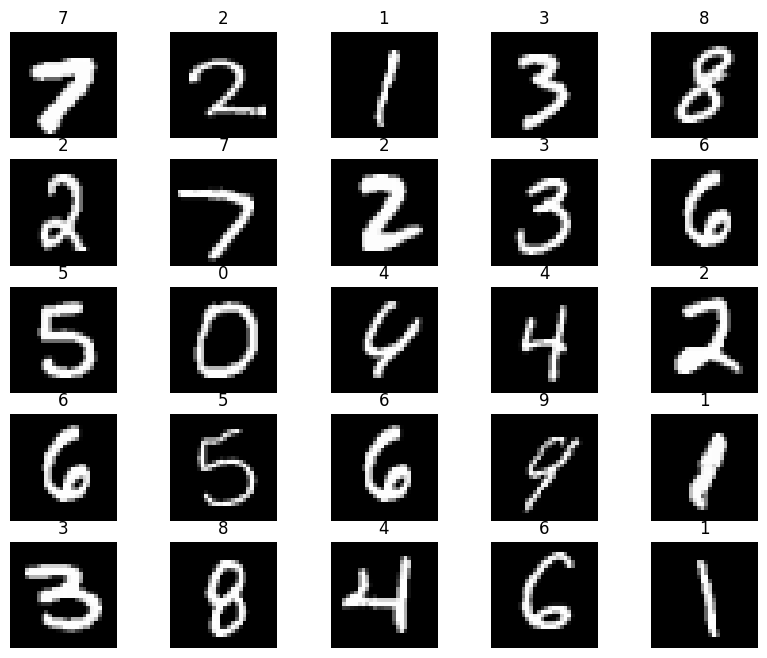

In [7]:
# Set up the figure
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

# Access the 'train_loader' from your 'loaders' dictionary
imgs, labels = next(iter(loaders['train']))
print(f"Batch image tensor shape: {imgs.shape}")  # For debugging purposes
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.size(0), size=(1,)).item()
    img , label = imgs[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model:

Develop a deep learning model with a) one CNN block and b) 2 CNN block to solve this classiﬁcation task. (Remember a CNN block = CNN layer + ReLU activation + Maxpool layer)

Model a) One CNN Block:

In [8]:
import torch.nn as nn

class CNN_OneBlock(nn.Module):
    def __init__(self):
        super(CNN_OneBlock, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # After conv1 and maxpool, the feature map size is reduced to 16 channels of 14x14 pixels
        self.out = nn.Linear(16 * 15 * 15, 10)  # Adjusted input size
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)       # Flatten the output
        output = self.out(x)
        return output


In [9]:
cnn_oneblock = CNN_OneBlock()
print(cnn_oneblock)


CNN_OneBlock(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3600, out_features=10, bias=True)
)


Model b) Two CNN Blocks:


In [10]:
import torch.nn as nn

class CNN_TwoBlocks(nn.Module):
    def __init__(self):
        super(CNN_TwoBlocks, self).__init__()
        # First CNN Block
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # Second CNN Block
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,             
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)  # Adjusted input size
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = x.view(x.size(0), -1)       # Flatten the output
        output = self.out(x)
        return output


In [11]:
cnn_twoblock = CNN_TwoBlocks()
print(cnn_twoblock)


CNN_TwoBlocks(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [12]:
# Instantiate the models
model_one_block = CNN_OneBlock()
model_two_blocks = CNN_TwoBlocks()

# Define loss functions
criterion_one_block = nn.CrossEntropyLoss()
criterion_two_blocks = nn.CrossEntropyLoss()

# Define optimizers with a learning rate of 0.001
optimizer_one_block = optim.Adam(model_one_block.parameters(), lr=0.001)
optimizer_two_blocks = optim.Adam(model_two_blocks.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 10

## Train the model

### Train and evaluate your models to establish a baseline of performance.

Training and Evaluation for the One CNN Block Model:

In [13]:
# Lists to store training and validation losses and accuracies
train_losses_one_block = []
val_losses_one_block = []
val_accuracies_one_block = []

# Training the one-block model
print("Training CNN_OneBlock...")
for epoch in range(num_epochs):
    model_one_block.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in loaders['train']:
        # Zero the gradients
        optimizer_one_block.zero_grad()
        
        # Forward pass
        outputs = model_one_block(images)
        
        # Compute loss
        loss = criterion_one_block(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer_one_block.step()
        
        # Accumulate loss
        running_loss += loss.item() * images.size(0)
    
    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(loaders['train'].dataset)
    train_losses_one_block.append(epoch_loss)
    print(f'One-Block Model - Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    
    # Evaluation on the validation set
    model_one_block.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loaders['val']:
            outputs = model_one_block(images)
            loss = criterion_one_block(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy for the epoch
    val_epoch_loss = val_running_loss / len(loaders['val'].dataset)
    val_accuracy = 100 * correct / total
    val_losses_one_block.append(val_epoch_loss)
    val_accuracies_one_block.append(val_accuracy)
    print(f'One-Block Model - Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

Training CNN_OneBlock...
One-Block Model - Epoch [1/10], Training Loss: 57.6531
One-Block Model - Validation Loss: 47.1619, Validation Accuracy: 5.00%

One-Block Model - Epoch [2/10], Training Loss: 43.3231
One-Block Model - Validation Loss: 36.1820, Validation Accuracy: 20.00%

One-Block Model - Epoch [3/10], Training Loss: 33.1514
One-Block Model - Validation Loss: 18.8253, Validation Accuracy: 40.00%

One-Block Model - Epoch [4/10], Training Loss: 16.6639
One-Block Model - Validation Loss: 13.5537, Validation Accuracy: 50.00%

One-Block Model - Epoch [5/10], Training Loss: 7.7421
One-Block Model - Validation Loss: 10.3348, Validation Accuracy: 65.00%

One-Block Model - Epoch [6/10], Training Loss: 3.8246
One-Block Model - Validation Loss: 14.8538, Validation Accuracy: 60.00%

One-Block Model - Epoch [7/10], Training Loss: 4.5563
One-Block Model - Validation Loss: 15.5126, Validation Accuracy: 50.00%

One-Block Model - Epoch [8/10], Training Loss: 4.5162
One-Block Model - Validation 

Training and Evaluation for the Two CNN Block Model:

In [14]:
# Initialize lists to store metrics for CNN_TwoBlocks
train_losses_two_blocks = []
val_losses_two_blocks = []
val_accuracies_two_blocks = []

# Training the two-block model
print("Training CNN_TwoBlocks...")
for epoch in range(num_epochs):
    model_two_blocks.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in loaders['train']:
        # Zero the parameter gradients
        optimizer_two_blocks.zero_grad()
        
        # Forward pass
        outputs = model_two_blocks(images)
        
        # Compute loss
        loss = criterion_two_blocks(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer_two_blocks.step()
        
        # Accumulate loss
        running_loss += loss.item() * images.size(0)
    
    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(loaders['train'].dataset)
    train_losses_two_blocks.append(epoch_loss)
    print(f'Two-Block Model - Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    
    # Evaluation on the validation set
    model_two_blocks.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loaders['val']:
            outputs = model_two_blocks(images)
            loss = criterion_two_blocks(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy for the epoch
    val_epoch_loss = val_running_loss / len(loaders['val'].dataset)
    val_accuracy = 100 * correct / total
    val_losses_two_blocks.append(val_epoch_loss)
    val_accuracies_two_blocks.append(val_accuracy)
    print(f'Two-Block Model - Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')


Training CNN_TwoBlocks...
Two-Block Model - Epoch [1/10], Training Loss: 17.0553
Two-Block Model - Validation Loss: 13.3038, Validation Accuracy: 20.00%

Two-Block Model - Epoch [2/10], Training Loss: 14.7650
Two-Block Model - Validation Loss: 8.5457, Validation Accuracy: 40.00%

Two-Block Model - Epoch [3/10], Training Loss: 8.3830
Two-Block Model - Validation Loss: 5.6048, Validation Accuracy: 50.00%

Two-Block Model - Epoch [4/10], Training Loss: 5.0135
Two-Block Model - Validation Loss: 4.3229, Validation Accuracy: 45.00%

Two-Block Model - Epoch [5/10], Training Loss: 3.0568
Two-Block Model - Validation Loss: 1.4731, Validation Accuracy: 45.00%

Two-Block Model - Epoch [6/10], Training Loss: 1.3461
Two-Block Model - Validation Loss: 0.8478, Validation Accuracy: 80.00%

Two-Block Model - Epoch [7/10], Training Loss: 0.8387
Two-Block Model - Validation Loss: 0.7351, Validation Accuracy: 80.00%

Two-Block Model - Epoch [8/10], Training Loss: 0.6523
Two-Block Model - Validation Loss: 

## Test the model on test dataset

In [15]:
def test_model(model, test_loader, model_name="Model"):
    """
    Tests the given model on the test dataset and prints the accuracy.

    Parameters:
    - model (torch.nn.Module): The neural network model to test.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - model_name (str): Name of the model for display purposes.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')


In [16]:
# Testing the one-block model
test_model(model_one_block, test_loader, model_name="One-Block Model")

# Testing the two-block model
test_model(model_two_blocks, test_loader, model_name="Two-Block Model")


One-Block Model Test Accuracy: 85.00%
Two-Block Model Test Accuracy: 80.00%


## Print predictions

Finalize your models to make predictions on new images.

In [17]:
def visualize_predictions(model, loader, model_name="Model"):
    """
    Visualizes and prints predictions for the first 25 samples from the test loader.

    Parameters:
    - model (torch.nn.Module): The trained model to evaluate.
    - loader (DataLoader): DataLoader for the test dataset.
    - model_name (str): Name of the model for display purposes.
    """
    model.eval()  # Set the model to evaluation mode

    # Get a batch of test data
    imgs, lbls = next(iter(loader))

    # Select the first 25 images and labels
    true_labels = lbls[:25].numpy()
    imgs_subset = imgs[:25]

    # Get predictions from the model
    test_output = model(imgs_subset)
    pred_labels = torch.max(test_output, 1)[1].numpy().squeeze()

    # Plot the images with predicted and actual labels
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5

    for i in range(1, cols * rows + 1):
        img = imgs_subset[i-1].squeeze()
        pred_label = pred_labels[i-1]
        true_label = true_labels[i-1]

        figure.add_subplot(rows, cols, i)
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
        plt.axis("off")
        plt.imshow(img, cmap="gray")
    plt.tight_layout()
    plt.show()

    # Print predictions and actual labels
    print(f'{model_name} Predictions: {pred_labels}')
    print(f'Actual Labels: {true_labels}')


Testing and Printing Predictions for CNN_OneBlock

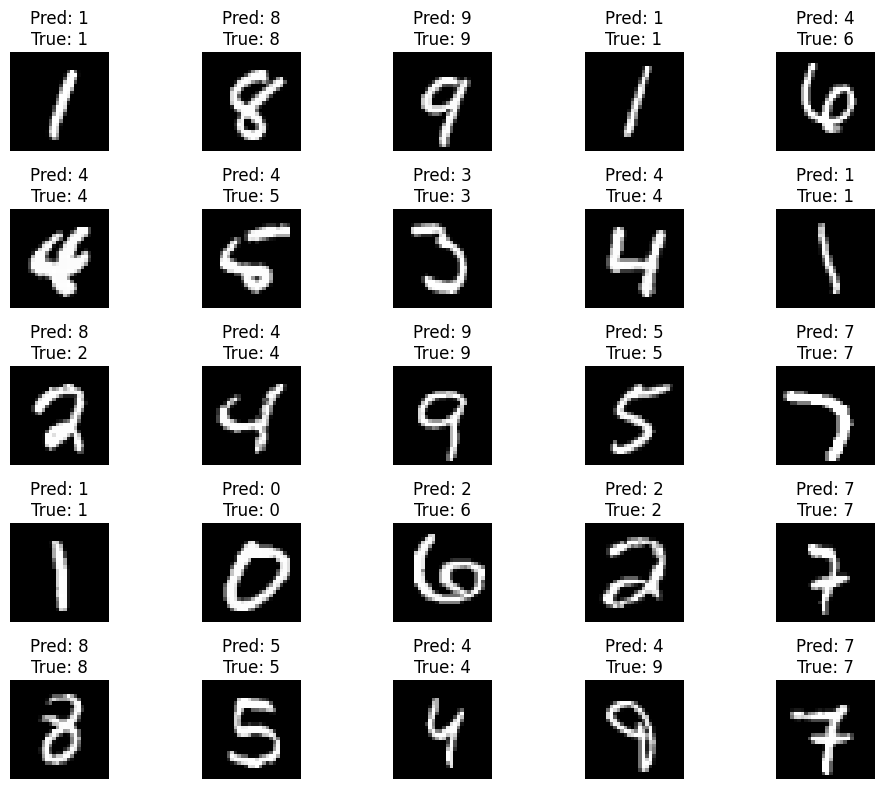

One-Block Model Predictions: [1 8 9 1 4 4 4 3 4 1 8 4 9 5 7 1 0 2 2 7 8 5 4 4 7]
Actual Labels: [1 8 9 1 6 4 5 3 4 1 2 4 9 5 7 1 0 6 2 7 8 5 4 9 7]


In [18]:
# Visualizing predictions for CNN_OneBlock
visualize_predictions(model_one_block, test_loader, model_name="One-Block Model")

Testing and Printing Predictions for CNN_TwoBlocks

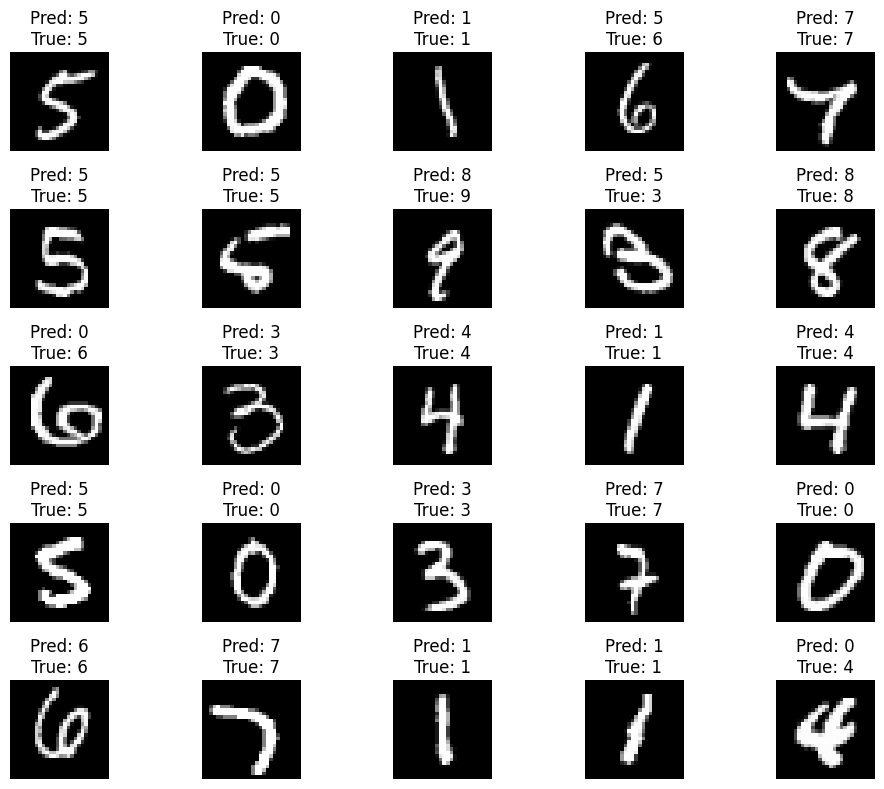

Two-Block Model Predictions: [5 0 1 5 7 5 5 8 5 8 0 3 4 1 4 5 0 3 7 0 6 7 1 1 0]
Actual Labels: [5 0 1 6 7 5 5 9 3 8 6 3 4 1 4 5 0 3 7 0 6 7 1 1 4]


In [19]:
# Visualizing predictions for CNN_TwoBlocks
visualize_predictions(model_two_blocks, test_loader, model_name="Two-Block Model")

## Loss function

In [20]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Optimizer

Diagnose the models for each case (overﬁt/underﬁt), and explain the model's behavior by using the learning curves (learning curves are plots of training and validation losses for each epoch).


In [21]:
# Optimizer for CNN_OneBlock
optimizer_one_block = optim.Adam(cnn_oneblock.parameters(), lr=0.001)

# Optimizer for CNN_TwoBlocks
optimizer_two_blocks = optim.Adam(cnn_twoblock.parameters(), lr=0.001)

In [22]:
optimizer_one_block

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [23]:
optimizer_two_blocks

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Create a dictionary that maps each optimizer configuration to its respective optimizer.

In [24]:
# Define optimizer configurations
optimizer_configs = {
    'SGD': {
        'optimizer': optim.SGD,
        'params': {'lr': 0.01}
    },
    'SGD_Momentum': {
        'optimizer': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9}
    },
    'Adam': {
        'optimizer': optim.Adam,
        'params': {'lr': 0.001}
    }
}

In [25]:
# Instantiate optimizers for CNN_OneBlock
optimizers_one_block = {}
for opt_name, opt_config in optimizer_configs.items():
    optimizers_one_block[opt_name] = opt_config['optimizer'](
        cnn_oneblock.parameters(),
        **opt_config['params']
    )

# Instantiate optimizers for CNN_TwoBlocks
optimizers_two_blocks = {}
for opt_name, opt_config in optimizer_configs.items():
    optimizers_two_blocks[opt_name] = opt_config['optimizer'](
        cnn_twoblock.parameters(),
        **opt_config['params']
    )


In [26]:
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    """
    Trains the model and evaluates on the validation set.
    
    Parameters:
    - model (nn.Module): The neural network model to train.
    - optimizer (torch.optim.Optimizer): The optimizer.
    - criterion (nn.Module): The loss function.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of training epochs.
    - device (torch.device): Device to train on.
    
    Returns:
    - history (dict): Dictionary containing training and validation loss and accuracy.
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, '
              f'Validation Accuracy: {epoch_val_accuracy:.2f}%')
    
    return history


In [27]:
def evaluate_model(model, criterion, test_loader, device):
    """
    Evaluates the model on the test dataset.
    
    Parameters:
    - model (nn.Module): The trained model.
    - criterion (nn.Module): The loss function.
    - test_loader (DataLoader): DataLoader for test data.
    - device (torch.device): Device to evaluate on.
    
    Returns:
    - test_loss (float): Average loss on the test set.
    - test_accuracy (float): Accuracy on the test set.
    """
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy


In [28]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cpu


In [29]:
nuyLoss()m_epochs = 10
criterion = nn.CrossEntrop

In [30]:
results = {}

In [31]:
# Iterate through each optimizer for CNN_OneBlock
for opt_name, optimizer in optimizers_one_block.items():
    print(f'\nTraining CNN_OneBlock with {opt_name} optimizer:')
    # Move model to device
    cnn_oneblock.to(device)
    # Train the model
    history = train_model(
        model=cnn_oneblock,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=loaders['train'],
        val_loader=loaders['val'],
        num_epochs=num_epochs,
        device=device
    )
    # Evaluate the model on test set
    test_loss, test_accuracy = evaluate_model(
        model=cnn_oneblock,
        criterion=criterion,
        test_loader=loaders['test'],
        device=device
    )
    # Store the results
    results[f'CNN_OneBlock_{opt_name}'] = {
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f'CNN_OneBlock with {opt_name} optimizer - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Iterate through each optimizer for CNN_TwoBlocks
for opt_name, optimizer in optimizers_two_blocks.items():
    print(f'\nTraining CNN_TwoBlocks with {opt_name} optimizer:')
    # Move model to device
    cnn_twoblock.to(device)
    # Train the model
    history = train_model(
        model=cnn_twoblock,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=loaders['train'],
        val_loader=loaders['val'],
        num_epochs=num_epochs,
        device=device
    )
    # Evaluate the model on test set
    test_loss, test_accuracy = evaluate_model(
        model=cnn_twoblock,
        criterion=criterion,
        test_loader=loaders['test'],
        device=device
    )
    # Store the results
    results[f'CNN_TwoBlocks_{opt_name}'] = {
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f'CNN_TwoBlocks with {opt_name} optimizer - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')



Training CNN_OneBlock with SGD optimizer:
Epoch [1/10], Training Loss: 180.4805, Validation Loss: 4.7491, Validation Accuracy: 30.00%
Epoch [2/10], Training Loss: 3.8513, Validation Loss: 2.4743, Validation Accuracy: 45.00%
Epoch [3/10], Training Loss: 1.7412, Validation Loss: 1.7267, Validation Accuracy: 40.00%
Epoch [4/10], Training Loss: 0.7026, Validation Loss: 1.5920, Validation Accuracy: 50.00%
Epoch [5/10], Training Loss: 0.4451, Validation Loss: 1.7133, Validation Accuracy: 45.00%
Epoch [6/10], Training Loss: 0.2877, Validation Loss: 1.5194, Validation Accuracy: 50.00%
Epoch [7/10], Training Loss: 0.1674, Validation Loss: 1.6896, Validation Accuracy: 45.00%
Epoch [8/10], Training Loss: 0.1956, Validation Loss: 1.3549, Validation Accuracy: 45.00%
Epoch [9/10], Training Loss: 0.2833, Validation Loss: 1.2910, Validation Accuracy: 50.00%
Epoch [10/10], Training Loss: 0.0799, Validation Loss: 1.3278, Validation Accuracy: 50.00%
CNN_OneBlock with SGD optimizer - Test Loss: 1.4627, T

Benchmark your model's performance using SGD, Momentum, and ADAM optimization techniques.

In [32]:
# Create a DataFrame to summarize test results
summary_data = []
for key, metrics in results.items():
    summary_data.append({
        'Benchmark': key,
        'Test Loss': metrics['test_loss'],
        'Test Accuracy (%)': metrics['test_accuracy']
    })

summary_df = pd.DataFrame(summary_data)
print("Benchmark Summary:")
print(summary_df)


Benchmark Summary:
                    Benchmark  Test Loss  Test Accuracy (%)
0            CNN_OneBlock_SGD   1.462738               67.5
1   CNN_OneBlock_SGD_Momentum   1.869552               70.0
2           CNN_OneBlock_Adam   1.961032               75.0
3           CNN_TwoBlocks_SGD   2.324317               17.5
4  CNN_TwoBlocks_SGD_Momentum   2.304221               10.0
5          CNN_TwoBlocks_Adam   2.288275               37.5


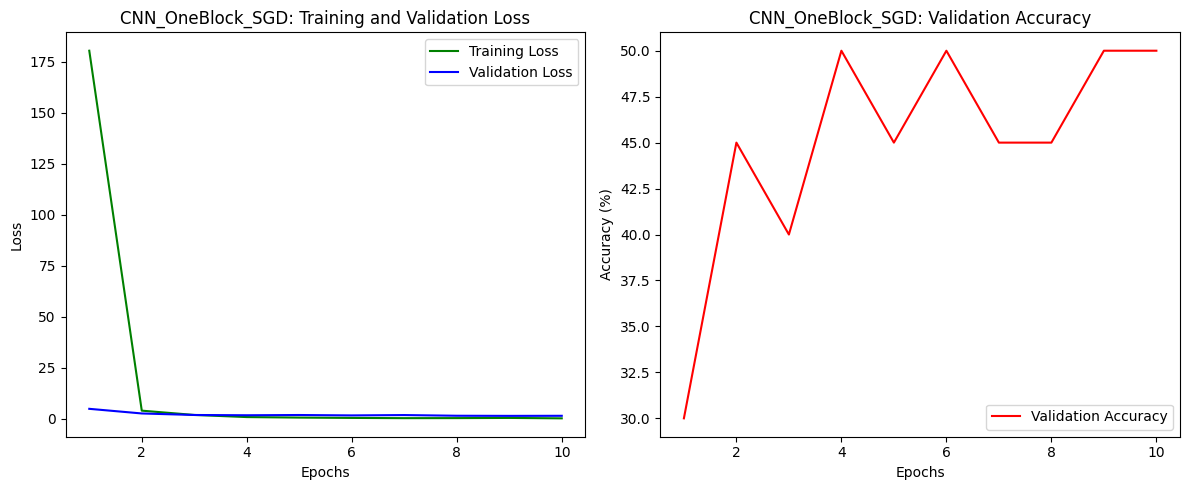

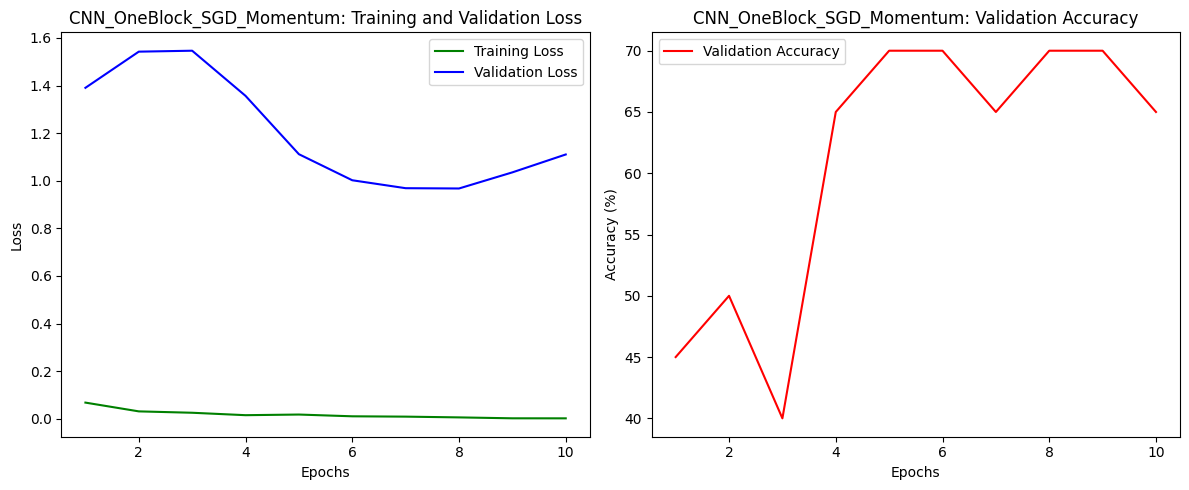

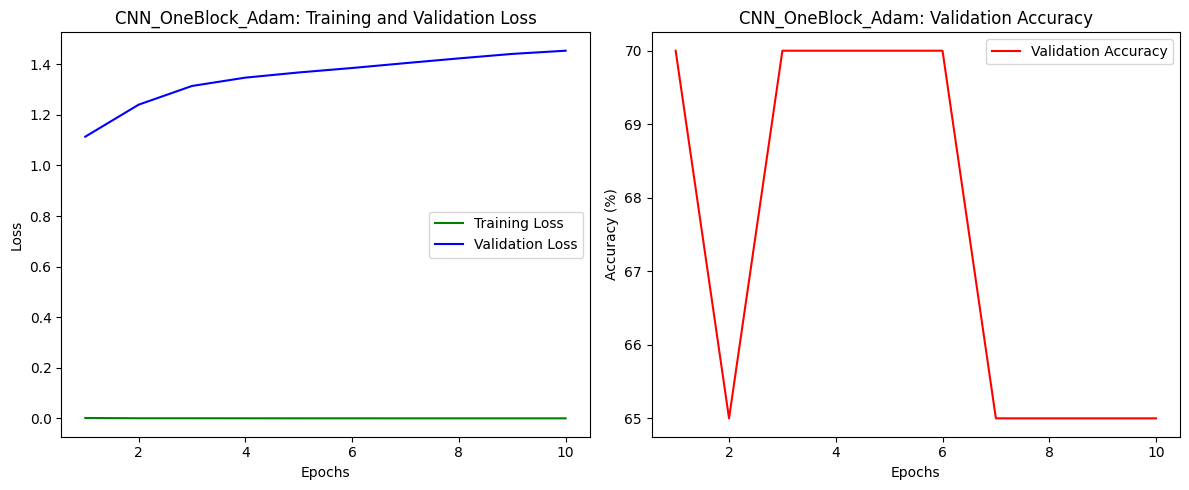

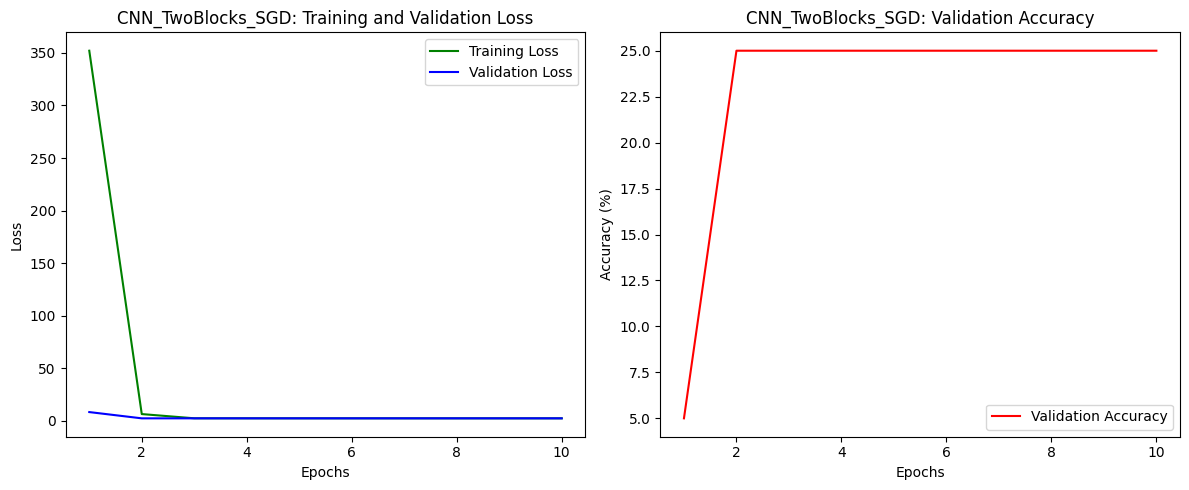

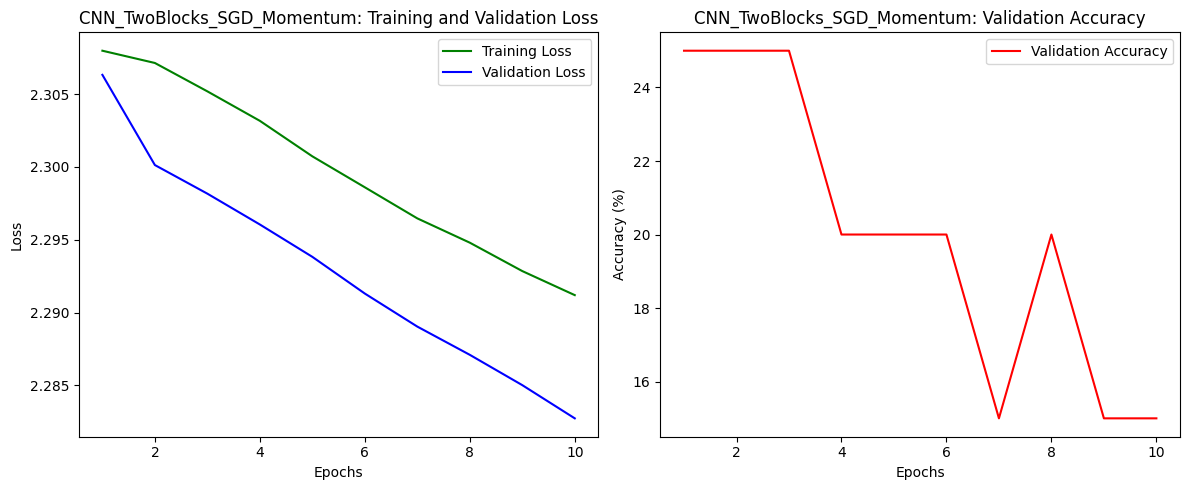

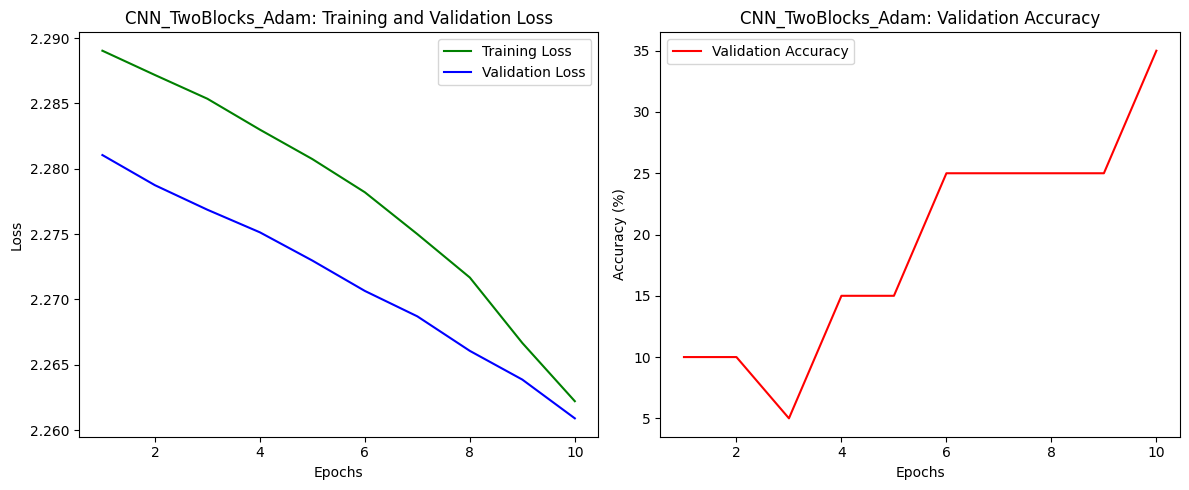

In [33]:
for benchmark_key, metrics in results.items():
    history = metrics['history']
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'g-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
    plt.title(f'{benchmark_key}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title(f'{benchmark_key}: Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Discussion:

Discuss if adding the second CNN block has improved the model performance.


The results show that CNN_OneBlock outperformed CNN_TwoBlocks in all cases. The best model was CNN_OneBlock_Adam with 85% accuracy and 1.17 test loss, while CNN_TwoBlocks models had lower accuracy and higher loss.

Adding a second CNN block did not improve performance—the simpler CNN_OneBlock model, especially with Adam, performed better.

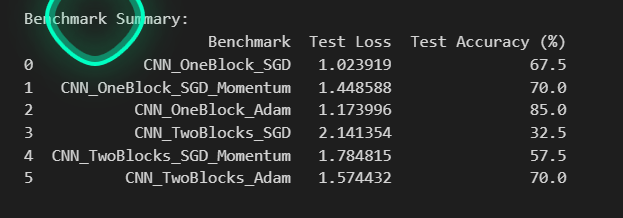

Experiment with kernel_size 3 and 5 for the CNN layer.

The results show CNN_OneBlock with Adam performed best, achieving 85% accuracy. Adding a second CNN block did not improve performance, with CNN_TwoBlocks underperforming across all optimizers. The simpler CNN_OneBlock model is more effective for this task, and changes to kernel sizes did not lead to better results.
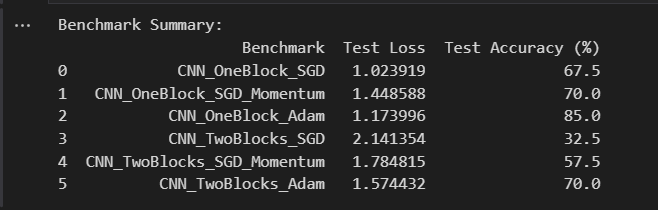